In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import cv2
import torch.optim as optim
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")
import fastai
import gc

from fastai.vision.all import *
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from typing import Tuple, Union
from collections import OrderedDict
from torch.cuda.amp import autocast
from glob import glob

SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
# labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
# labels_df= labels_df.head(5000)

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]
test_df = labels_df[labels_df['Patient_ID'].isin(test_df_patients)]

# test_df=test_df.head(1568)

print('test size', test_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                    splitter=RandomSplitter(valid_pct=0, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(test_df, bs=64, shuffle=False)

100%|██████████| 14/14 [00:00<00:00, 29.29it/s]


test size 22356
test size 22356


In [3]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)
            elif pool_type == 'lp':
                lp_pool = F.lp_pool2d(x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(lp_pool)
            elif pool_type == 'lse':
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp(lse_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1,
                                 padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out
class DenseNet121_CBAM_full(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM_full, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        # Apply attention only in deeper blocks to save FLOPs
        self.att_block1 = CBAM(256)
        self.att_block2 = CBAM(512)
        self.att_block3 = CBAM(1024)
        self.att_block4 = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        x = self.features.denseblock1(x)
        x = self.att_block1(x)
        x = self.features.transition1(x)

        x = self.features.denseblock2(x)
        x = self.att_block2(x)
        x = self.features.transition2(x)

        x = self.features.denseblock3(x)
        x = self.att_block3(x)
        x = self.features.transition3(x)

        x = self.features.denseblock4(x)
        x = self.att_block4(x)

        x = self.features.norm5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam_full =  DenseNet121_CBAM_full(
    num_classes=14,
    dropout=0.5,
)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 178MB/s]


In [4]:
class DenseNet121_CBAM(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        # Apply attention only in deeper blocks to save FLOPs
        #self.att_block1 = CBAM(256)
        #self.att_block2 = CBAM(512)
        self.att_block3 = CBAM(1024)
        self.att_block4 = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        x = self.features.denseblock1(x)
        #x = self.att_block1(x)
        x = self.features.transition1(x)

        x = self.features.denseblock2(x)
        #x = self.att_block2(x)
        x = self.features.transition2(x)

        x = self.features.denseblock3(x)
        x = self.att_block3(x)
        x = self.features.transition3(x)

        x = self.features.denseblock4(x)
        x = self.att_block4(x)

        x = self.features.norm5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam =  DenseNet121_CBAM(
    num_classes=14,
    dropout=0.5,
)

In [5]:
class DenseNet121_CBAM_after(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM_after, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        # Apply attention only in deeper blocks to save FLOPs
        #self.att_block1 = CBAM(256)
        #self.att_block2 = CBAM(512)
        #self.att_block3 = CBAM(1024)
        self.cbam = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam_after =  DenseNet121_CBAM_after(
    num_classes=14,
    dropout=0.5,
)

In [6]:
def get_roc_auc(model_arch,model_path):
    arch = model_arch
    learner =  Learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()])
    #learner.model = torch.nn.DataParallel(learner.model)
    learner.load(model_path, weights_only=False)
    learner.to('cuda')
    learner.freeze()
    preds, y_test = learner.get_preds(ds_idx=0)
    roc_auc = roc_auc_score(y_test, preds)

    plt.figure(figsize=(12, 10))
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    scores=[]
    for i in range(0,14):
            
        label_roc_auc_score=roc_auc_score(y_test[:,i],preds[:,i])
        fpr_rf, tpr_rf, _ = roc_curve(y_test[:,i], preds[:,i])
            
        # Add this curve to the same plot
        plt.plot(fpr_rf, tpr_rf, label=f"{disease_labels[i]} (AUC={round(label_roc_auc_score, 4)})")
        scores.append(label_roc_auc_score)
    print('ROC_AUC_Labels:', list(zip(disease_labels,scores)))   
    
    print('VGGAttN AVERAGE', sum(scores)/len(scores))
    print(f'VGGAttN SCORE: {roc_auc}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Classes')
    plt.legend(loc='best')
   
    
    # Save the combined figure
    plt.savefig(f"/kaggle/working/roc_curves_all_full_data.png", dpi=300, bbox_inches='tight')
    plt.show()
    del learner
    gc.collect()
    return {
        'roc_auc': roc_auc,
        'preds': preds,
        'y_test': y_test
    }

ROC_AUC_Labels: [('Atelectasis', 0.8395592789417343), ('Consolidation', 0.8305066955745134), ('Infiltration', 0.7386574815481594), ('Pneumothorax', 0.9168554481288859), ('Edema', 0.921435625372725), ('Emphysema', 0.9426133574256558), ('Fibrosis', 0.8416994796727285), ('Effusion', 0.8994214256707405), ('Pneumonia', 0.7791305550433338), ('Pleural_Thickening', 0.8362119368806539), ('Cardiomegaly', 0.9382151907377977), ('Nodule', 0.8153105500027202), ('Mass', 0.8879484374641428), ('Hernia', 0.9660176081931108)]
VGGAttN AVERAGE 0.8681130764754931
VGGAttN SCORE: 0.8681130764754931


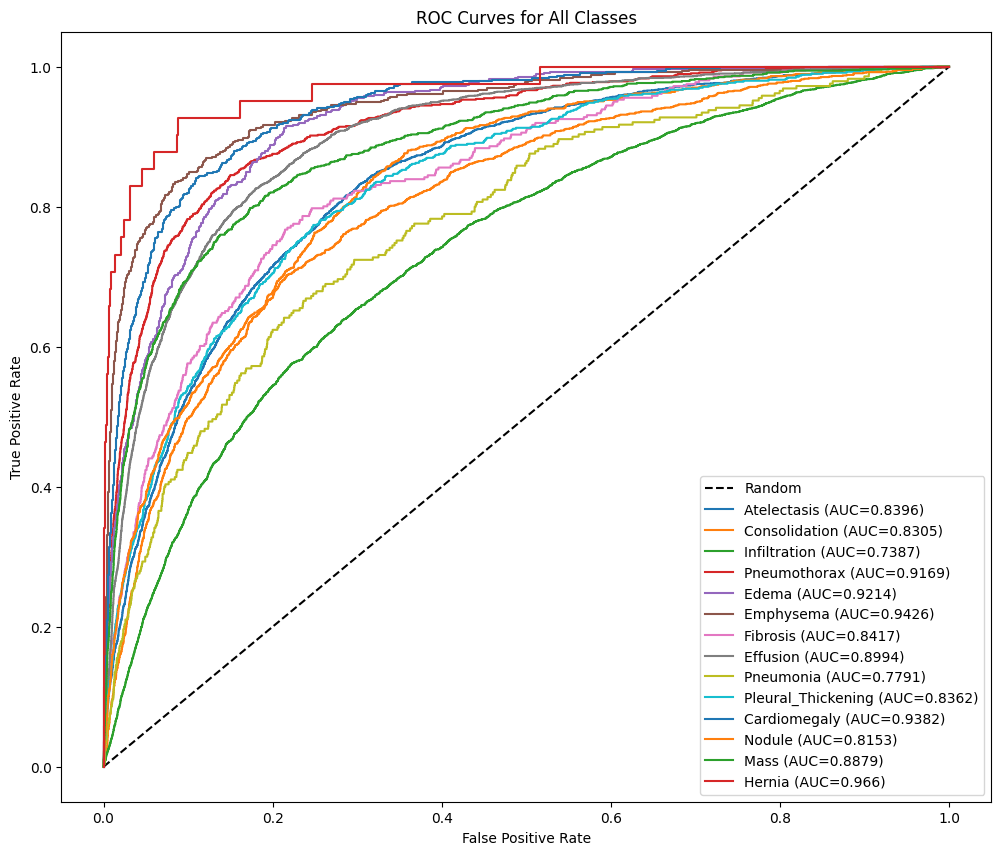

In [7]:
result = get_roc_auc(model_dense_cbam,'/kaggle/input/densenet-cbam-2-block-weights/best_model_densenet121_cbam_2_block_stage_2_training_bceloss')
preds = result['preds']

ROC_AUC_Labels: [('Atelectasis', 0.8288571900439936), ('Consolidation', 0.8143916626354122), ('Infiltration', 0.7266393615955119), ('Pneumothorax', 0.8937308147264693), ('Edema', 0.9109877561008293), ('Emphysema', 0.9292537384477252), ('Fibrosis', 0.821471953774435), ('Effusion', 0.8918616560424344), ('Pneumonia', 0.7766009963838889), ('Pleural_Thickening', 0.8171279520351206), ('Cardiomegaly', 0.9219098007264509), ('Nodule', 0.7994601878265766), ('Mass', 0.8705823624742237), ('Hernia', 0.9577578244973576)]
VGGAttN AVERAGE 0.8543309469507452
VGGAttN SCORE: 0.8543309469507452


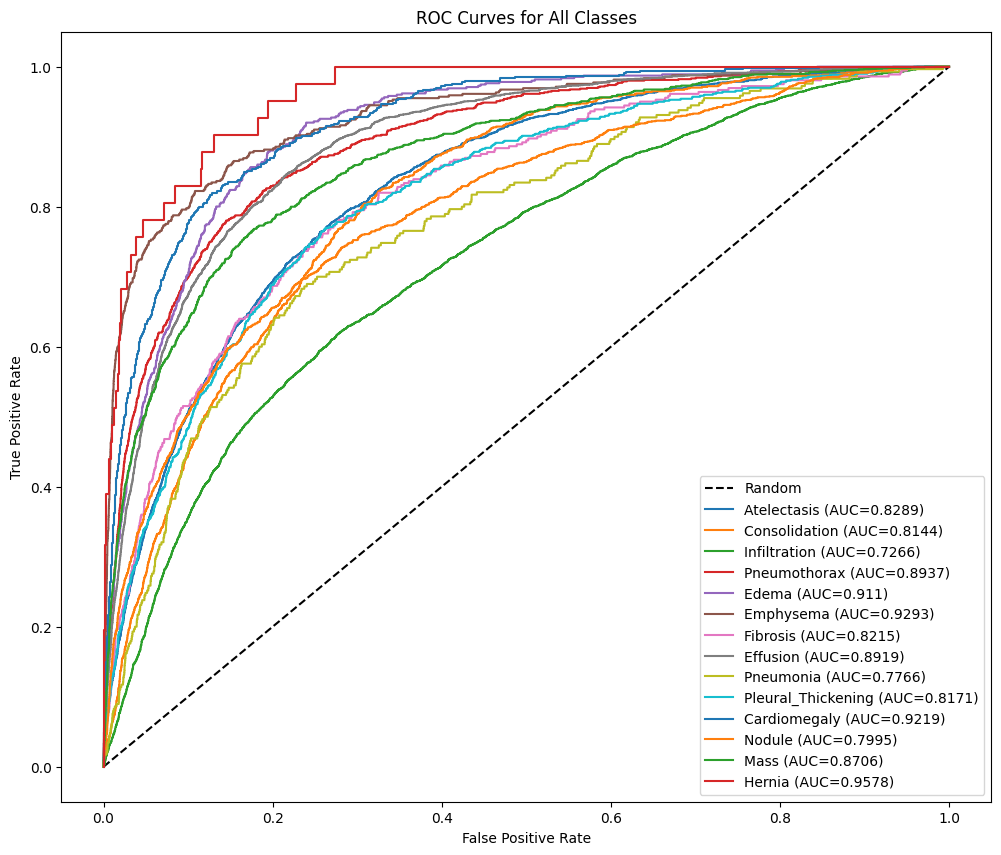

In [8]:
result = get_roc_auc(model_dense_cbam_full,'/kaggle/input/dense-cbam/best_model_densenet121_cbam_full_stage_2_training_bceloss')
preds = result['preds']

ROC_AUC_Labels: [('Atelectasis', 0.8265332868620123), ('Consolidation', 0.814913674970208), ('Infiltration', 0.7229738293547235), ('Pneumothorax', 0.8929256197943144), ('Edema', 0.9068508155316614), ('Emphysema', 0.9240664847298106), ('Fibrosis', 0.8028552825213991), ('Effusion', 0.8902655643312377), ('Pneumonia', 0.7702493616329695), ('Pleural_Thickening', 0.8058212898286808), ('Cardiomegaly', 0.9223702848530144), ('Nodule', 0.7844771420106587), ('Mass', 0.864701977853375), ('Hernia', 0.904042452031063)]
VGGAttN AVERAGE 0.8452176475932236
VGGAttN SCORE: 0.8452176475932235


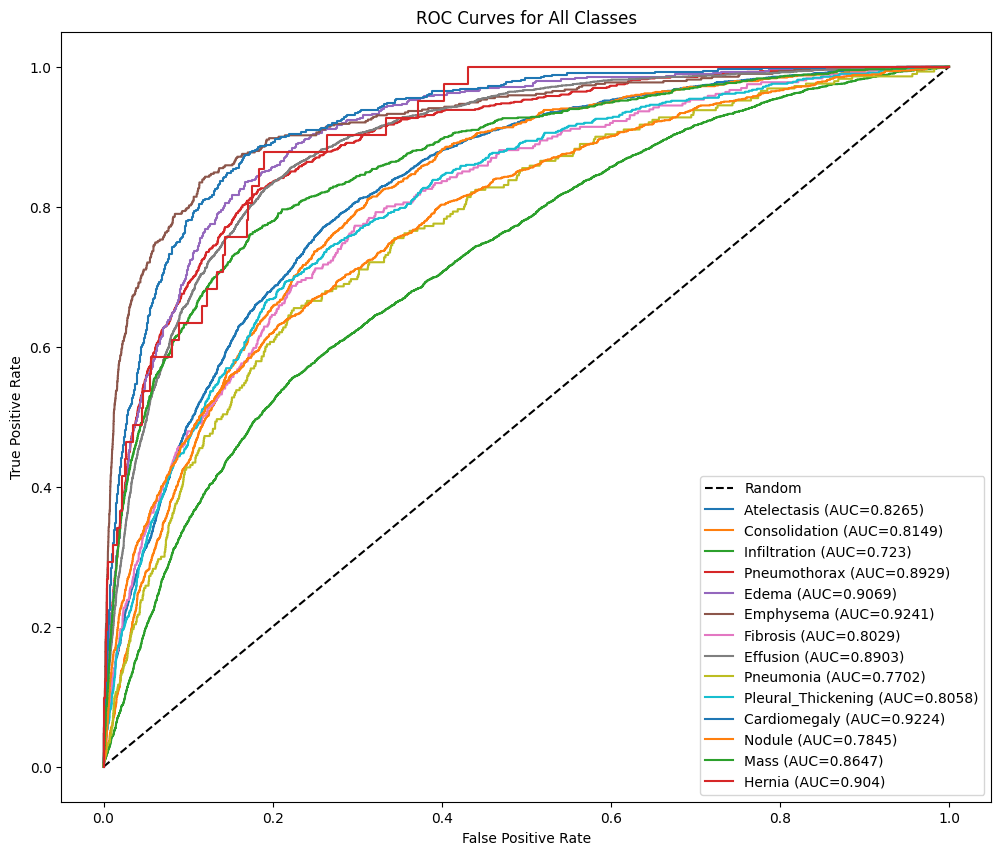

In [9]:
result = get_roc_auc(model_dense_cbam_after,'/kaggle/input/dense-cbam/best_model_densenet121backbone_cbam_stage_2')
preds = result['preds']

In [7]:
class VGG_CBAM(nn.Module):
    def __init__(self, num_classes, dropout=None):
        super(VGG_CBAM, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        # Wrap each conv block with CBAM.
        # Note: Adjust gate_channels based on the output channels of each block.
        self.conv_block1 = nn.Sequential(
            *list(net.features.children())[0:6],
            #CBAM(gate_channels=64)
        )
        self.conv_block2 = nn.Sequential(
            *list(net.features.children())[7:13],
            #CBAM(gate_channels=128)
        )
        self.conv_block3 = nn.Sequential(
            *list(net.features.children())[14:23],
            CBAM(gate_channels=256)
        )
        self.conv_block4 = nn.Sequential(
            *list(net.features.children())[24:33],
            CBAM(gate_channels=512)
        )
        self.conv_block5 = nn.Sequential(
            *list(net.features.children())[34:43],
            CBAM(gate_channels=512)
        )
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = nn.Dropout(dropout) if dropout is not None else None
        # The classifier now expects concatenated features from global pooling and cross-attention outputs.
        self.cls = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        self.reset_parameters(self.cls)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        # Pass input through each VGG block (with CBAM enhancement)
        block1 = self.conv_block1(x)              # output channels: 64
        pool1 = F.max_pool2d(block1, 2, 2)          # /2
        block2 = self.conv_block2(pool1)            # output channels: 128
        pool2 = F.max_pool2d(block2, 2, 2)          # /4
        block3 = self.conv_block3(pool2)            # output channels: 256
        pool3 = F.max_pool2d(block3, 2, 2)          # /8
        block4 = self.conv_block4(pool3)            # output channels: 512
        pool4 = F.max_pool2d(block4, 2, 2)          # /16
        block5 = self.conv_block5(pool4)            # output channels: 512
        pool5 = F.max_pool2d(block5, 2, 2)          # /32

        N = pool5.size(0)
        # Global features from pool5 using average pooling
        g = self.pool(pool5).view(N, 512)

        # # Cross-attention between pool3 and pool5 features
        # a1, g1 = self.attn1(pool3, pool5)
        # # Cross-attention between pool4 and pool5 features
        # a2, g2 = self.attn2(pool4, pool5)

        # Concatenate the global and attention-based features
        # g_hat = torch.cat((g, g1, g2), dim=1)  # final feature vector

        if self.dpt is not None:
            g = self.dpt(g)

        # Final classification
        out = self.cls(g)
        return out

model_vgg_cbam = VGG_CBAM(14, 0.5)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 78.8MB/s] 


In [8]:
class VGG_CBAM_full(nn.Module):
    def __init__(self, num_classes, dropout=None):
        super(VGG_CBAM_full, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        # Wrap each conv block with CBAM.
        # Note: Adjust gate_channels based on the output channels of each block.
        self.conv_block1 = nn.Sequential(
            *list(net.features.children())[0:6],
            CBAM(gate_channels=64)
        )
        self.conv_block2 = nn.Sequential(
            *list(net.features.children())[7:13],
            CBAM(gate_channels=128)
        )
        self.conv_block3 = nn.Sequential(
            *list(net.features.children())[14:23],
            CBAM(gate_channels=256)
        )
        self.conv_block4 = nn.Sequential(
            *list(net.features.children())[24:33],
            CBAM(gate_channels=512)
        )
        self.conv_block5 = nn.Sequential(
            *list(net.features.children())[34:43],
            CBAM(gate_channels=512)
        )
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = nn.Dropout(dropout) if dropout is not None else None
        # The classifier now expects concatenated features from global pooling and cross-attention outputs.
        self.cls = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        self.reset_parameters(self.cls)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        # Pass input through each VGG block (with CBAM enhancement)
        block1 = self.conv_block1(x)              # output channels: 64
        pool1 = F.max_pool2d(block1, 2, 2)          # /2
        block2 = self.conv_block2(pool1)            # output channels: 128
        pool2 = F.max_pool2d(block2, 2, 2)          # /4
        block3 = self.conv_block3(pool2)            # output channels: 256
        pool3 = F.max_pool2d(block3, 2, 2)          # /8
        block4 = self.conv_block4(pool3)            # output channels: 512
        pool4 = F.max_pool2d(block4, 2, 2)          # /16
        block5 = self.conv_block5(pool4)            # output channels: 512
        pool5 = F.max_pool2d(block5, 2, 2)          # /32

        N = pool5.size(0)
        # Global features from pool5 using average pooling
        g = self.pool(pool5).view(N, 512)

        # # Cross-attention between pool3 and pool5 features
        # a1, g1 = self.attn1(pool3, pool5)
        # # Cross-attention between pool4 and pool5 features
        # a2, g2 = self.attn2(pool4, pool5)

        # Concatenate the global and attention-based features
        # g_hat = torch.cat((g, g1, g2), dim=1)  # final feature vector

        if self.dpt is not None:
            g = self.dpt(g)

        # Final classification
        out = self.cls(g)
        return out

model_vgg_cbam_full = VGG_CBAM_full(14, 0.5)

In [9]:
class VGG16_CBAM_after(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(VGG16_CBAM_after, self).__init__()
        base = models.vgg16_bn(pretrained=True)

        # Full backbone (keep as-is)
        self.features = base.features

        # Add LKA after norm5
        self.cbam = CBAM(512)

        # Classification head
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout) if dropout else nn.Identity()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)      # DenseNet121 full features (includes norm5)
        x = self.cbam(x)           # LKA-enhanced final feature map
        x = self.pool(x).flatten(1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_vgg_cbam_after = VGG16_CBAM_after(num_classes=14, dropout=0.5)

ROC_AUC_Labels: [('Atelectasis', 0.8473764412629767), ('Consolidation', 0.8211923427275007), ('Infiltration', 0.7457512417641827), ('Pneumothorax', 0.9211040697219725), ('Edema', 0.921604337405755), ('Emphysema', 0.9431231415094163), ('Fibrosis', 0.8256806035620033), ('Effusion', 0.9039412088387611), ('Pneumonia', 0.7887144210003219), ('Pleural_Thickening', 0.8345426876817871), ('Cardiomegaly', 0.9387102005440261), ('Nodule', 0.8302216905929412), ('Mass', 0.8920003759221841), ('Hernia', 0.9510610275271474)]
VGGAttN AVERAGE 0.8689302707186412
VGGAttN SCORE: 0.8689302707186412


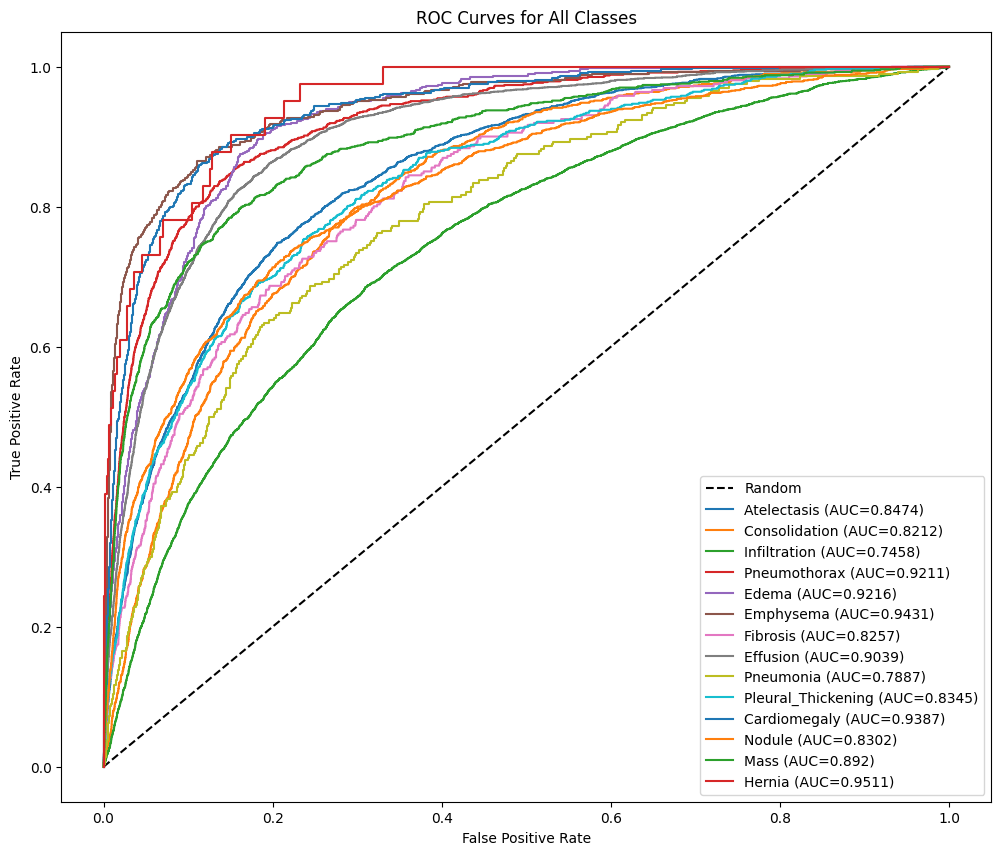

In [13]:
result = get_roc_auc(model_vgg_cbam_full,'/kaggle/input/vgg-cbam/best_model_VGG_CBAM_stage_2')
preds = result['preds']

ROC_AUC_Labels: [('Atelectasis', 0.8509170824782966), ('Consolidation', 0.8242097758060684), ('Infiltration', 0.7444441966914663), ('Pneumothorax', 0.918854187033199), ('Edema', 0.9216319705557136), ('Emphysema', 0.9422324660221721), ('Fibrosis', 0.8384030870778362), ('Effusion', 0.9013681063484174), ('Pneumonia', 0.7915487081076519), ('Pleural_Thickening', 0.8310839639712482), ('Cardiomegaly', 0.9385746489839628), ('Nodule', 0.8314502517107937), ('Mass', 0.8859721795727818), ('Hernia', 0.9529497275703207)]
VGGAttN AVERAGE 0.8695457394235664
VGGAttN SCORE: 0.8695457394235663


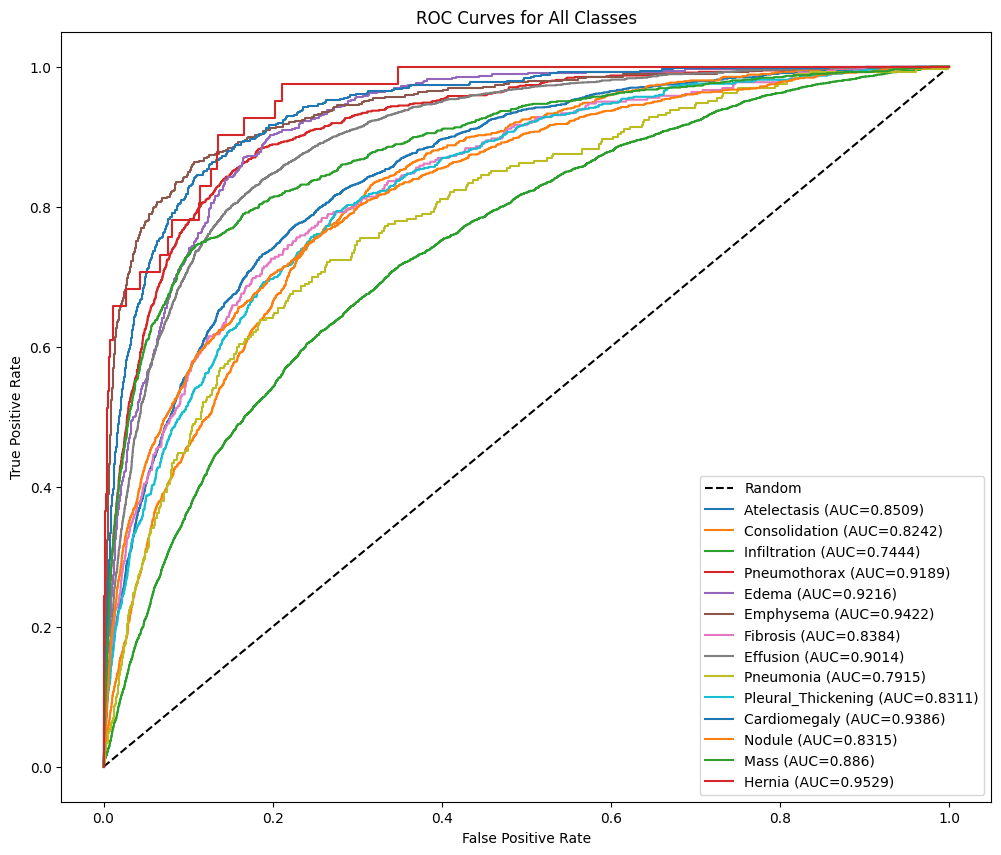

In [14]:
result = get_roc_auc(model_vgg_cbam,'/kaggle/input/vgg-cbam/best_model_vgg_cbam_3_block_stage_2')
preds = result['preds']

ROC_AUC_Labels: [('Atelectasis', 0.8114768455456882), ('Consolidation', 0.7990160528605211), ('Infiltration', 0.7130229858346024), ('Pneumothorax', 0.8802540521252884), ('Edema', 0.893597224366612), ('Emphysema', 0.9133757188963576), ('Fibrosis', 0.7825459576244663), ('Effusion', 0.8821990262723083), ('Pneumonia', 0.7424049169107099), ('Pleural_Thickening', 0.786731855209353), ('Cardiomegaly', 0.8935683846140305), ('Nodule', 0.7638723863531532), ('Mass', 0.8336765517444866), ('Hernia', 0.809828781908702)]
VGGAttN AVERAGE 0.8218264814475915
VGGAttN SCORE: 0.8218264814475915


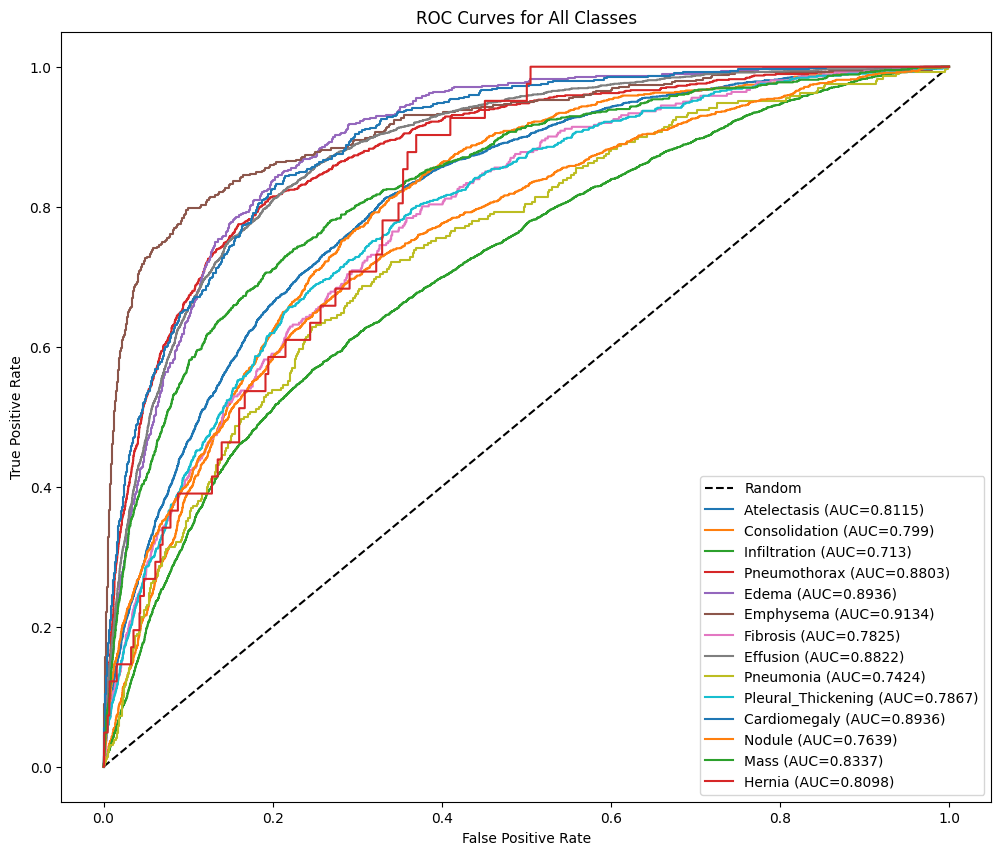

In [15]:
result = get_roc_auc(model_vgg_cbam_after,'/kaggle/input/vgg-cbam/best_model_vgg16bn_cbam_after_stage_2_training_bceloss')
preds = result['preds']